# Restaurant Recommendation System Model Creation (Yelp User Review Dataset)

![](http://blog.yelp.com/wp-content/uploads/2020/02/Full-Article-Feature-Image-900x354-1.png)

* [Introduction](#introduction)
* [Data](#data)
* [Preprocessing Data](#preprocessing-data) 
    * [Get Dummies from attributes](#get-dummies) 
* [Content Based Filtering Model](#content-based)
    * [K-nearest neighbours](#knn)       
* [Collaboritive Filtering - Model](#collaboritive)
    * [SVD - Singular Value Decomposition](#svd)  
        - [Building a Utility Matrix](#u-matrix)
        - [Transposing the Matrix](#transpose-matrix)
        - [Decomposing the Matrix](#decompose-matrix)
        - [Generating a correlation Matrix](#gen-corr-matrix)  
        - [Isolating the most popular restaurant from the Correlation Matrix](#isolate)
        - [Recommend highly correlated Restaurants](#recommend)                   
    * [Neural Network - keras](#NN-keras)    
        - [Prediction](#prediction)
        - [Cosine similarity](#cos-similarity)
        - [Recommendation](#recommendation)

<a id="introduction"></a>
# Introduction

In this notebook, we are building a recommender system using Yelp Dataset. In order to build this system, we had two main approaches which are Content-Based Filtering and Collaborative Filtering. 

> * **Content-Based Filtering:** It is based on the features of the restaurants rather than the user features. The idea is if the user likes a restaurant then he/she will like the other similar restaurants.
>  
> * **Collaborative Filtering:** It is based on the assumption that people like restaurants similar to other restaurants they like, and restaurants that are liked by other people with similar tastes.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/Dataset_Agreement.pdf


<a id="data"></a>
# Data

We are using subsets of each table since we have a large dataset to work with. For this notebook, we used _business_ and _review_ tables.

In [2]:
# import the data (chunksize returns jsonReader for iteration)
businesses = pd.read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json", lines=True, orient='columns', chunksize=1000000)
reviews = pd.read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json", lines=True, orient='columns', chunksize=1000000)

In [3]:
# read the data 
for business in businesses:
    subset_business = business
    break
    
for review in reviews:
    subset_review = review
    break

In [4]:
# peak the tables
display(subset_business.head(2))
display(subset_review.head(2))

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52


<a id="preprocessing-data"></a>
# Preprocessing the Data

We chose Toronto since it has the highest number of reviews in Canada. The restaurant is the most popular category among businesses. 

In [5]:
# Businesses in Toronto and currently open business
city = subset_business[(subset_business['city'] == 'Toronto') & (subset_business['is_open'] == 1)]
toronto = city[['business_id','name','address', 'categories', 'attributes','stars']]
toronto

,business_id,name,address,categories,attributes,stars
9,EosRKXIGeSWFYWwpkbhNnA,Xtreme Couture,700 Kipling Avenue Etobicoke,"Martial Arts, Gyms, Fitness & Instruction, Act...","{'GoodForKids': 'True', 'ByAppointmentOnly': '...",3.0
26,1wWneWD_E1pBIyVpdHMaQg,Air Jordan Store,306 Yonge Street,"Shopping, Shoe Stores, Fashion","{'RestaurantsPriceRange2': '3', 'BikeParking':...",4.0
52,9JCjKd6eFXsAMVwouTh_4Q,Bath and Body Works,1900 Eglintion Ave E,"Cosmetics & Beauty Supply, Shopping, Beauty & ...","{'RestaurantsPriceRange2': '2', 'ByAppointment...",3.5
73,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,"Vietnamese, Restaurants","{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...",4.0
74,OT-8IUWo_2M-rHddjzz_Cg,Equipment Sales and Long Term Rentals - Redlin...,"510 Coronation Dr. Unit #18, Unit 18","Event Planning & Services, Photo Booth Rentals...",{'WheelchairAccessible': 'True'},1.5
...,...,...,...,...,...,...
209351,0hudPyuCBlKg79OwKBw-eQ,The Black Bull,298 Queen Street W,"Pubs, Bars, Nightlife","{'Alcohol': 'u'full_bar'', 'NoiseLevel': 'u'av...",2.5
209359,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,1075 Martin Grove Road,"Restaurants, Mediterranean","{'GoodForKids': 'True', 'HasTV': 'True', 'Rest...",4.0
209374,BtTCTHwoIfr3fBQjaOkpIw,Starbucks,81 Front Street E,"Coffee & Tea, Food","{'WiFi': 'u'free'', 'BusinessParking': '{'gara...",4.0
209377,n2BKYb8aw4AhRKLkdUjQRg,Steak & Cheese & Quick Pita Restaurant,199 College St,"Sandwiches, Restaurants","{'OutdoorSeating': 'False', 'Alcohol': 'u'none...",2.5


In [6]:
# getting just restaurants from Toronto business
rest = toronto[toronto['categories'].str.contains('Restaurant.*')==True].reset_index()
rest   

,index,business_id,name,address,categories,attributes,stars
0,73,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,"Vietnamese, Restaurants","{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...",4.0
1,110,8k62wYhDVq1-652YbJi5eg,Tim Hortons,90 Adelaide Street W,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...","{'OutdoorSeating': 'False', 'RestaurantsDelive...",3.0
2,149,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,3-1265 York Mills Road,"Fast Food, Restaurants, Chicken Shop","{'NoiseLevel': ''loud'', 'BusinessParking': '{...",3.0
3,150,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,2048 Danforth Avenue,"Coffee & Tea, Restaurants, Sandwiches, Food","{'DogsAllowed': 'False', 'OutdoorSeating': 'Tr...",4.5
4,161,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,2201 Yonge Street,"Steakhouses, Restaurants, Nightlife, Seafood, ...","{'GoodForKids': 'True', 'RestaurantsGoodForGro...",3.5
...,...,...,...,...,...,...,...
5459,209300,thzyiQZb16zD8wMliaEfRQ,Sushi Supreme,1995 Yonge Street,"Sushi Bars, Restaurants, Japanese","{'Ambience': '{'romantic': False, 'intimate': ...",4.0
5460,209315,eUi3O-8Gqh_nJ_ZhO-25gQ,Get & Go Burrito,"1077 Wilson Avenue, Unit 8","Mexican, Restaurants","{'BusinessParking': '{'garage': False, 'street...",3.5
5461,209328,yFQCdWr_k1pTObzHPGis9Q,Grasshopper Restaurant,310 College Street,"Vegan, Restaurants, Vegetarian, Salad","{'DogsAllowed': 'False', 'BikeParking': 'True'...",4.0
5462,209359,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,1075 Martin Grove Road,"Restaurants, Mediterranean","{'GoodForKids': 'True', 'HasTV': 'True', 'Rest...",4.0


<a id="get-dummies"></a>
* ** Get Dummies from attributes and categories columns**

> In "attributes" column has nested attributes. In order to create a feature table, we need to separate those nested attributes into their own columns. Therefore, the following functions will be used to achieve this goal.

In [7]:
# Function that extract keys from the nested dictionary
def extract_keys(attr, key):
    if attr == None:
        return "{}"
    if key in attr:
        return attr.pop(key)

# convert string to dictionary
import ast
def str_to_dict(attr):
    if attr != None:
        return ast.literal_eval(attr)
    else:
        return ast.literal_eval("{}")    

In [8]:
# get dummies from nested attributes
rest['BusinessParking'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'BusinessParking')), axis=1)
rest['Ambience'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Ambience')), axis=1)
rest['GoodForMeal'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'GoodForMeal')), axis=1)
rest['Dietary'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Dietary')), axis=1)
rest['Music'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Music')), axis=1)

In [9]:
rest

,index,business_id,name,address,categories,attributes,stars,BusinessParking,Ambience,GoodForMeal,Dietary,Music
0,73,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,"Vietnamese, Restaurants","{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...",4.0,"{'garage': False, 'street': True, 'validated':...","{'romantic': False, 'intimate': False, 'classy...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
1,110,8k62wYhDVq1-652YbJi5eg,Tim Hortons,90 Adelaide Street W,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...","{'OutdoorSeating': 'False', 'RestaurantsDelive...",3.0,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",{},{},{}
2,149,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,3-1265 York Mills Road,"Fast Food, Restaurants, Chicken Shop","{'NoiseLevel': ''loud'', 'RestaurantsTableServ...",3.0,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
3,150,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,2048 Danforth Avenue,"Coffee & Tea, Restaurants, Sandwiches, Food","{'DogsAllowed': 'False', 'OutdoorSeating': 'Tr...",4.5,"{'garage': False, 'street': False, 'validated'...",{},{},{},{}
4,161,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,2201 Yonge Street,"Steakhouses, Restaurants, Nightlife, Seafood, ...","{'GoodForKids': 'True', 'RestaurantsGoodForGro...",3.5,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...","{'dessert': False, 'latenight': False, 'lunch'...",{},"{'dj': False, 'background_music': False, 'no_m..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5459,209300,thzyiQZb16zD8wMliaEfRQ,Sushi Supreme,1995 Yonge Street,"Sushi Bars, Restaurants, Japanese","{'RestaurantsAttire': 'u'casual'', 'GoodForKid...",4.0,"{'garage': False, 'street': True, 'validated':...","{'romantic': False, 'intimate': False, 'classy...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
5460,209315,eUi3O-8Gqh_nJ_ZhO-25gQ,Get & Go Burrito,"1077 Wilson Avenue, Unit 8","Mexican, Restaurants","{'NoiseLevel': ''average'', 'RestaurantsDelive...",3.5,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
5461,209328,yFQCdWr_k1pTObzHPGis9Q,Grasshopper Restaurant,310 College Street,"Vegan, Restaurants, Vegetarian, Salad","{'DogsAllowed': 'False', 'BikeParking': 'True'...",4.0,"{'garage': False, 'street': True, 'validated':...","{'touristy': False, 'hipster': False, 'romanti...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
5462,209359,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,1075 Martin Grove Road,"Restaurants, Mediterranean","{'GoodForKids': 'True', 'HasTV': 'True', 'Rest...",4.0,{},"{'romantic': False, 'intimate': False, 'classy...",{},{},{}


In [10]:
# create table with attribute dummies
df_attr = pd.concat([ rest['attributes'].apply(pd.Series), rest['BusinessParking'].apply(pd.Series),
                    rest['Ambience'].apply(pd.Series), rest['GoodForMeal'].apply(pd.Series), 
                    rest['Dietary'].apply(pd.Series) ], axis=1)
df_attr_dummies = pd.get_dummies(df_attr)
df_attr_dummies

,RestaurantsTakeOut_False,RestaurantsTakeOut_True,Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',GoodForKids_False,...,latenight_False,latenight_True,lunch_False,lunch_True,dinner_False,dinner_True,brunch_False,brunch_True,breakfast_False,breakfast_True
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0,1,1,0,1,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,1,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0,1,1,0,1,0
5460,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0
5461,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,1,1,0,1,0
5462,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# get dummies from categories
df_categories_dummies = pd.Series(rest['categories']).str.get_dummies(',')
df_categories_dummies

,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Afghan,African,Alternative Medicine,American (New),American (Traditional),...,Ukrainian,Vegan,Vegetarian,Vietnamese,Waffles,Whiskey Bars,Wine Bars,Wineries,Women's Clothing,Yelp Events
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5461,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# pull out names and stars from rest table 
result = rest[['name','stars']]
result

,name,stars
0,Mi Mi Restaurant,4.0
1,Tim Hortons,3.0
2,Chick-N-Joy,3.0
3,Zav Coffee Shop & Gallery,4.5
4,The Keg Steakhouse + Bar,3.5
...,...,...
5459,Sushi Supreme,4.0
5460,Get & Go Burrito,3.5
5461,Grasshopper Restaurant,4.0
5462,Q's Shawarma,4.0


In [13]:
# Concat all tables and drop Restaurant column
df_final = pd.concat([df_attr_dummies, df_categories_dummies, result], axis=1)
df_final.drop('Restaurants',inplace=True,axis=1)

In [14]:
# map floating point stars to an integer
mapper = {1.0:1,1.5:2, 2.0:2, 2.5:3, 3.0:3, 3.5:4, 4.0:4, 4.5:5, 5.0:5}
df_final['stars'] = df_final['stars'].map(mapper)

In [15]:
# Final table for the models 
df_final

,RestaurantsTakeOut_False,RestaurantsTakeOut_True,Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',GoodForKids_False,...,Vegetarian,Vietnamese,Waffles,Whiskey Bars,Wine Bars,Wineries,Women's Clothing,Yelp Events,name,stars
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,Mi Mi Restaurant,4
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Tim Hortons,3
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Chick-N-Joy,3
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Zav Coffee Shop & Gallery,5
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,The Keg Steakhouse + Bar,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,Sushi Supreme,4
5460,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,Get & Go Burrito,4
5461,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Grasshopper Restaurant,4
5462,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Q's Shawarma,4


<a id="content-based"></a>
# Content Based Filtering- Model

In this section, we are going to build a system that recognizes the similarity between restaurants based on specific features and recommends restaurants that are most similar to a particular restaurant. __df_final__ (features) table used to build this system.

<a id="knn"></a>
## 1. K-Nearest Neighbours model (KNN)
> 
>    - Split the data into train and test set  (80:20)
>    - Instantiate and fit the model
>    - Test the model: we used the last row as a validation set (we didn't include this last row to train the model)
>    - Recommend restaurants for the validation set (the last restaurant in the df_final table)

In [16]:
# Create X (all the features) and y (target)
X = df_final.iloc[:,:-2]
y = df_final['stars']

* **Split the data into train and test set (80:20)**

In [17]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.2, random_state=1)

* **Instantiate and fit the model**

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_knn, y_train_knn)

#y_pred = knn.predict(X_test)

accuracy_train = knn.score(X_train_knn, y_train_knn)
accuracy_test = knn.score(X_test_knn, y_test_knn)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

Score on training set: 0.5671471059254175
Score on test set: 0.5343092406221409


The restaurant name of the validation set is "Steak & Cheese & Quick Pita Restaurant".

In [19]:
# look at the last row for the test
display(df_final.iloc[-1:])

# look at the restaurant name from the last row.
print("Validation set (Restaurant name): ", df_final['name'].values[-1])

,RestaurantsTakeOut_False,RestaurantsTakeOut_True,Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',GoodForKids_False,...,Vegetarian,Vietnamese,Waffles,Whiskey Bars,Wine Bars,Wineries,Women's Clothing,Yelp Events,name,stars
5463,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,Steak & Cheese & Quick Pita Restaurant,3


Validation set (Restaurant name):  Steak & Cheese & Quick Pita Restaurant


* **Test the model:** 

> We used the last row as a validation set (we didn't include this last row for modeling). 

In [20]:
# test set from the df_final table (only last row): Restaurant name: "Steak & Cheese & Quick Pita Restaurant"
test_set = df_final.iloc[-1:,:-2]

# validation set from the df_final table (exclude the last row)
X_val =  df_final.iloc[:-1,:-2]
y_val = df_final['stars'].iloc[:-1]

In [21]:
# fit model with validation set
n_knn = knn.fit(X_val, y_val)

After fitting the KNN model to the validation set, we are going to find the distances between the validation set and the other restaurants based on their similar features. 

In [22]:
# distances and indeces from validation set (Steak & Cheese & Quick Pita Restaurant)
distances, indeces =  n_knn.kneighbors(test_set)
#n_knn.kneighbors(test_set)[1][0]

# create table distances and indeces from "Steak & Cheese & Quick Pita Restaurant"
final_table = pd.DataFrame(n_knn.kneighbors(test_set)[0][0], columns = ['distance'])
final_table['index'] = n_knn.kneighbors(test_set)[1][0]
final_table.set_index('index')

,distance
index,
1157,2.449490
2391,2.449490
3610,2.828427
4003,3.000000
1855,3.162278
399,3.316625
3320,3.316625
2620,3.316625
1080,3.316625


We are creating the following ***result*** table which displays similar restaurants to "Steak & Cheese & Quick Pita Restaurant" by their distances. Based on this recommendation system, the short distance means having more similarity to "Steak & Cheese & Quick Pita Restaurant". 

In [23]:
# get names of the restaurant that similar to the "Steak & Cheese & Quick Pita Restaurant"
result = final_table.join(df_final,on='index')
result[['distance','index','name','stars']].head(5)

,distance,index,name,stars
0,2.449490,1157,City Fried Chicken and Pizza,4
1,2.449490,2391,The Empire,4
2,2.828427,3610,Roti Time,4
3,3.000000,4003,Taste of Shawarma,3
4,3.162278,1855,George's Deli & BBQ,4


The "Steak & Cheese & Quick Pita Restaurant" is an authentic Lebanese cuisine (sandwiches). **Hooray!!!** We got our first recommendations from our model. All of those restaurants are have a common main menu which is making sandwiches.

------------------------

The problem of the Content-Based Filtering Method is that it doesn't capture any information about users' preferences since it only cares about restaurant features. Next, we will implement the Collaborative Filtering Methods.

<a id="collaboritive"></a>
# Collaboritive Filtering - Model

In this section, we use the Collaborative Filtering technique to make a recommendation to restaurant users. This technique is based on the idea that similar users can have a similar restaurant preference. 

We are implementing the following machine learning techniques to build a recommender system:
1. Singular Value Decomposition model (SVD)
2. Neural Network (Keras)

<a id="svd"></a>
## 1. Singular Value Decomposition model (SVD)

In [24]:
# looking at the columns of subset_review table
subset_review.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [25]:
# pull out needed columns from subset_review table
df_review = subset_review[['user_id','business_id','stars', 'date']]
df_review

,user_id,business_id,stars,date
0,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11
3,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,2011-05-27 05:30:52
4,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,2017-01-14 21:56:57
...,...,...,...,...
999995,D5uuGWFxVKyY7ti104yy4A,Yl05MqCs9xRzrJFkGWLpgA,2,2017-08-13 16:28:56
999996,eXhwli2CzubJ058MEXtCsg,os9fE0YwboRi9PDZZ7gf2w,5,2013-08-27 22:23:07
999997,gAGUItPJ16hLyAln6MtkeA,Ej_TupknUGM1f3V5lDc9IA,5,2016-05-02 05:36:44
999998,WJrx5OjI8Ux2RNFDa3HKyA,IcHVYlgNGR-Zz8fnceiJ6g,4,2014-05-17 17:27:17


In [26]:
# pull out names and addresses of the restaurants from rest table
restaurant = rest[['business_id', 'name', 'address']]
restaurant

,business_id,name,address
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,90 Adelaide Street W
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,3-1265 York Mills Road
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,2048 Danforth Avenue
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,2201 Yonge Street
...,...,...,...
5459,thzyiQZb16zD8wMliaEfRQ,Sushi Supreme,1995 Yonge Street
5460,eUi3O-8Gqh_nJ_ZhO-25gQ,Get & Go Burrito,"1077 Wilson Avenue, Unit 8"
5461,yFQCdWr_k1pTObzHPGis9Q,Grasshopper Restaurant,310 College Street
5462,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,1075 Martin Grove Road


In [27]:
# combine df_review and restaurant table
combined_business_data = pd.merge(df_review, restaurant, on='business_id')
combined_business_data

,user_id,business_id,stars,date,name,address
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4,2017-06-06 19:04:10,Levetto,"382 Spadina Avenue, Main Floor"
1,Nq6e5N8bjgD9B46O4va_zA,qUWqjjjfpB2-4P3He5rsKw,4,2017-10-24 23:16:12,Levetto,"382 Spadina Avenue, Main Floor"
2,wPLEzIlIUnTgc0lkJL_TmQ,qUWqjjjfpB2-4P3He5rsKw,4,2017-02-19 20:12:25,Levetto,"382 Spadina Avenue, Main Floor"
3,TX5kwQLpKUDvNf4mfdaH3Q,qUWqjjjfpB2-4P3He5rsKw,5,2016-06-22 22:57:44,Levetto,"382 Spadina Avenue, Main Floor"
4,fSYQ_oQ0wNGk2nMJLvNZJA,qUWqjjjfpB2-4P3He5rsKw,5,2016-12-19 22:45:59,Levetto,"382 Spadina Avenue, Main Floor"
...,...,...,...,...,...,...
38412,9gCAt3MUi1gEr5t519ckRA,LPsbCMNL1GDQ4dRek8e8dA,5,2017-11-21 23:29:36,A&W,4841 Yonge Street
38413,73vq6eei0qwlpEFLrJXsmw,BZmZ9TTYkDe-Nm2UNAYzQQ,5,2013-05-15 14:12:14,The Friendly Thai,500 Queen St W
38414,EisUuXVeVJN_FcFiE-tqwA,CqN6eOajC383xL63tu8OAg,3,2014-10-31 00:56:56,John Anderson Hamburgers,2832 Victoria Park Avenue
38415,1wgmsFxmWQV-gZUXSWMg0A,C4O-xIlNZN6r0XzqtsVugw,1,2017-10-16 15:02:40,Swiss Chalet Rotisserie & Grill,"1560 Yonge St, Unit 107"


In [28]:
# the most POPULAR restaurants by stars.
combined_business_data.groupby('business_id')['stars'].count().sort_values(ascending=False).head()

business_id
h_4dPV9M9aYaBliH1Eoeeg    803
HkHTdTvzbn-bmeQv_-2u0Q    543
4m_hApwQ054v3ue_OxFmGw    478
9Eghhu_LzEJgDKNgisf3rg    473
A7waf6G3cvnLfAqKeLL8DA    433
Name: stars, dtype: int64

In [29]:
# see the NAME of the most popular restaurant
Filter = combined_business_data['business_id'] == 'h_4dPV9M9aYaBliH1Eoeeg'
print("Name: ", combined_business_data[Filter]['name'].unique())
print("Address:", combined_business_data[Filter]['address'].unique())

Name:  ['Wvrst']
Address: ['609 King Street W']


The popular restaurant by ratings is **"Wvrst"**. It is a beer bar and they have few locations in Toronto. But the popular one is located at "609 King Street W". 

Their webpage: https://wvrst.com/ 

<a id="u-matrix"></a>
* **Building a Utility Matrix (User-Restaurant Matrix)**

This matrix contains each user, each restaurant, and the rating each user gave to each restaurant. Notice this matrix will be sparse because every user doesn't review every restaurant.

In [30]:
# create a user-item matrix
rating_crosstab = combined_business_data.pivot_table(values='stars', index='user_id', columns='name', fill_value=0)
rating_crosstab.head()

name,00 Gelato,241 Pizza,3030,360 Restaurant,5 Spice Dining,7 Numbers Danforth,786 Halal Biryani House,98 Aroma,A Xiang,A&W,...,Yupdduk,Zav Coffee Shop & Gallery,Zaza Espresso Bar,Zeal Burgers,Zhang's Kitchen,deKEFIR,est Restaurant,gourmet kitchen,yuan yuan Chinese Restaurant,z-teca Gourmet Burritos
user_id,,,,,,,,,,,,,,,,,,,,,
--BumyUHiO_7YsHurb9Hkw,0.0,0,0.0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
--KQJPdrU0Md97DiOliDzw,0.0,0,0.0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
--Qh8yKWAvIP4V4K8ZPfHA,0.0,0,0.0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,3
--UOvCH5qEgdNQ8lzR8QYQ,0.0,0,0.0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,4,0,0,0,0,0
--cd_gA-9Q8gM9P2cTxEsQ,0.0,0,0.0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


<a id="transpose-matrix"></a>
* **Transposing the Matrix**

After transpose the matrix, users are represented by columns, and restaurants are represented by rows.

In [31]:
# shape of the Utility matrix (original matrix) 
rating_crosstab.shape

(22024, 853)

In [32]:
# Transpose the Utility matrix
X = rating_crosstab.values.T
X.shape

(853, 22024)

<a id="decompose-matrix"></a>
* **Decomposing the Matrix**

Now we use TruncatedSVD from sklearn to compress the transposed matrix into down to a number of rows by 12 matrices. All of the restaurants are in the rows. But the users will be compressed down to 12 components arbitrarily that represent a generalized view of users' tastes.  

In [33]:
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score


SVD = TruncatedSVD(n_components=12, random_state=17)
result_matrix = SVD.fit_transform(X)
result_matrix.shape

(853, 12)

<a id="gen-corr-matrix"></a>
* **Generating a Correlation Matrix**

We calculated PearsonR coefficient for every restaurant pair in the result_matrix. The correlation-based on similarities between users' tastes. 

In [34]:
# PearsonR coef 
corr_matrix = np.corrcoef(result_matrix)
corr_matrix.shape

(853, 853)

<a id="isolate"></a>
* **Isolating the most popular restaurant from the Correlation Matrix**

In our case, the most popular restaurant is "Wvrst". So we will extract the correlation values between "Wvrst" with all other restaurants from corr_matrix.

In [35]:
# get the index of the popular restaurant
restaurant_names = rating_crosstab.columns
restaurants_list = list(restaurant_names)

popular_rest = restaurants_list.index('Wvrst')
print("index of the popular restaurant: ", popular_rest) 

index of the popular restaurant:  832


In [36]:
# restaurant of interest 
corr_popular_rest = corr_matrix[popular_rest]
corr_popular_rest.shape  

(853,)

<a id="recommend"></a>
* **Recommend Highly Correlated Restaurants**

Now we will filter out the most correlated restaurant to "Wvrst" by applying the following conditions as shown below. **Yey!!!** There you go we have another recommender system.

In [37]:
list(restaurant_names[(corr_popular_rest < 1.0) & (corr_popular_rest > 0.9)])

['Cafe Monterey',
 'Cider House',
 'Home Sweet Home',
 'Shanghai Chinese Restaurant',
 'The Veggie Thali',
 'Toronto Big Bowl',
 'Vista Eatery']

In [38]:
display(rest[rest['name'] == 'Wvrst'])

,index,business_id,name,address,categories,attributes,stars,BusinessParking,Ambience,GoodForMeal,Dietary,Music
265,10280,h_4dPV9M9aYaBliH1Eoeeg,Wvrst,609 King Street W,"Canadian (New), Nightlife, Pubs, Restaurants, ...","{'RestaurantsGoodForGroups': 'True', 'Alcohol'...",4.0,"{'garage': False, 'street': True, 'validated':...","{'romantic': False, 'intimate': False, 'classy...","{'dessert': False, 'latenight': True, 'lunch':...",{},"{'dj': False, 'background_music': False, 'no_m..."


<a id="NN-keras"></a>
## 2. Neural Network Model - Keras

Finally, we’ll build a neural network and see how it compares to the other collaborative filtering approach. 

In [39]:
# create the copy of combined_business_data table
combined_business_data_keras = combined_business_data.copy()
combined_business_data_keras.head(1)

,user_id,business_id,stars,date,name,address
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4,2017-06-06 19:04:10,Levetto,"382 Spadina Avenue, Main Floor"


We are using LabelEncoder from sklearn to encode business and user id's. We will create variables that store unique users, restaurants, min_rating, and max_rating.

In [40]:
from sklearn.preprocessing import LabelEncoder

user_encode = LabelEncoder()

combined_business_data_keras['user'] = user_encode.fit_transform(combined_business_data_keras['user_id'].values)
n_users = combined_business_data_keras['user'].nunique()

item_encode = LabelEncoder()

combined_business_data_keras['business'] = item_encode.fit_transform(combined_business_data_keras['business_id'].values)
n_rests = combined_business_data_keras['business'].nunique()

combined_business_data_keras['stars'] = combined_business_data_keras['stars'].values#.astype(np.float32)

min_rating = min(combined_business_data_keras['stars'])
max_rating = max(combined_business_data_keras['stars'])

print(n_users, n_rests, min_rating, max_rating)

combined_business_data_keras

22024 975 1 5


,user_id,business_id,stars,date,name,address,user,business
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4,2017-06-06 19:04:10,Levetto,"382 Spadina Avenue, Main Floor",10462,815
1,Nq6e5N8bjgD9B46O4va_zA,qUWqjjjfpB2-4P3He5rsKw,4,2017-10-24 23:16:12,Levetto,"382 Spadina Avenue, Main Floor",8479,815
2,wPLEzIlIUnTgc0lkJL_TmQ,qUWqjjjfpB2-4P3He5rsKw,4,2017-02-19 20:12:25,Levetto,"382 Spadina Avenue, Main Floor",20756,815
3,TX5kwQLpKUDvNf4mfdaH3Q,qUWqjjjfpB2-4P3He5rsKw,5,2016-06-22 22:57:44,Levetto,"382 Spadina Avenue, Main Floor",10447,815
4,fSYQ_oQ0wNGk2nMJLvNZJA,qUWqjjjfpB2-4P3He5rsKw,5,2016-12-19 22:45:59,Levetto,"382 Spadina Avenue, Main Floor",14855,815
...,...,...,...,...,...,...,...,...
38412,9gCAt3MUi1gEr5t519ckRA,LPsbCMNL1GDQ4dRek8e8dA,5,2017-11-21 23:29:36,A&W,4841 Yonge Street,3664,318
38413,73vq6eei0qwlpEFLrJXsmw,BZmZ9TTYkDe-Nm2UNAYzQQ,5,2013-05-15 14:12:14,The Friendly Thai,500 Queen St W,2791,180
38414,EisUuXVeVJN_FcFiE-tqwA,CqN6eOajC383xL63tu8OAg,3,2014-10-31 00:56:56,John Anderson Hamburgers,2832 Victoria Park Avenue,5400,204
38415,1wgmsFxmWQV-gZUXSWMg0A,C4O-xIlNZN6r0XzqtsVugw,1,2017-10-16 15:02:40,Swiss Chalet Rotisserie & Grill,"1560 Yonge St, Unit 107",1013,189


Split the data into train and test sets.

In [41]:
from sklearn.model_selection import train_test_split

X = combined_business_data_keras[['user', 'business']].values
y = combined_business_data_keras['stars'].values

X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_keras.shape, X_test_keras.shape, y_train_keras.shape, y_test_keras.shape

((30733, 2), (7684, 2), (30733,), (7684,))

In [42]:
X_train_keras[:, 0]

array([ 6765, 15296,  4288, ..., 18131,  1477,  9226])

We will need another variable that stores the number of factors per user/restaurant for the model. This number can be arbitrary. But for the Collaborative filtering model it needs to be the same size for both users and restaurants. 

Finally, we will store users and restaurants into separate arrays for the train and test set. It is because in Keras they’ll each be defined as distinct inputs.

In [43]:
n_factors = 50

X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_test_array = [X_test_keras[:, 0], X_test_keras[:, 1]]

In [44]:
X_train_array, X_test_array

([array([ 6765, 15296,  4288, ..., 18131,  1477,  9226]),
  array([ 43, 665, 853, ..., 655,  90, 735])],
 [array([ 1152, 10827, 21546, ..., 13584,  2996, 12721]),
  array([245, 401, 304, ..., 670, 562, 440])])

Here, we’re going to use embeddings to represent each user and each restaurant in the data. To get these embeddings we need to do the dot product between the user vector and restaurant vector. As a result, we will have vectors of size n factors to capture the weights related to each user per restaurant. 

In order to increase the model performance, we add the "bias" to each embedding. We run the output of the dot product through a sigmoid layer and then scaling the result using the min and max ratings in the data. 

In [45]:
from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        
        return x
    
def Recommender(n_users, n_rests, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_factors)(restaurant)
    mb = EmbeddingLayer(n_rests, 1)(restaurant)   
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)  
    
    model = Model(inputs=[user, restaurant], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)  
    
    return model

Using TensorFlow backend.


In [46]:
keras_model = Recommender(n_users, n_rests, n_factors, min_rating, max_rating)
keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1101200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        48750       input_2[0][0]                    
____________________________________________________________________________________________

Let’s go ahead and train this for a few epochs and see what we get.

In [47]:
keras_model.fit(x=X_train_array, y=y_train_keras, batch_size=64,\
                          epochs=5, verbose=1, validation_data=(X_test_array, y_test_keras))

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30733 samples, validate on 7684 samples
Epoch 1/5
30733/30733 [==============================] - 5s 162us/step - loss: 1.9693 - val_loss: 1.8738
Epoch 2/5
30733/30733 [==============================] - 5s 150us/step - loss: 1.6453 - val_loss: 1.7492
Epoch 3/5
30733/30733 [==============================] - 5s 150us/step - loss: 1.0268 - val_loss: 1.6898
Epoch 4/5
30733/30733 [==============================] - 5s 150us/step - loss: 0.5182 - val_loss: 1.6808
Epoch 5/5
30733/30733 [==============================] - 5s 149us/step - loss: 0.2808 - val_loss: 1.6771


<a id="prediction"></a>
* **Prediction**

After creating the model now it's time to predict the test dataset. 

In [48]:
# prediction
predictions = keras_model.predict(X_test_array)

By creating the following table, we are able to see the model performance by comparing the actual stars and predictions.

In [49]:
# create the df_test table with prediction results
df_test = pd.DataFrame(X_test_keras[:,0])
df_test.rename(columns={0: "user"}, inplace=True)
df_test['business'] = X_test_keras[:,1]
df_test['stars'] = y_test_keras
df_test["predictions"] = predictions
df_test.head()

,user,business,stars,predictions
0,1152,245,4,3.248009
1,10827,401,5,3.137012
2,21546,304,2,3.294755
3,16376,551,4,4.058130
4,16076,805,3,3.429742


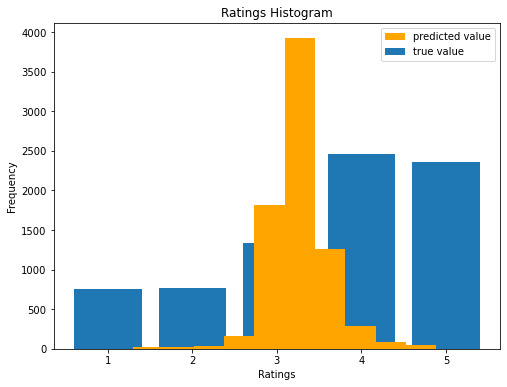

In [50]:
# Plotting the distribution of actual and predicted stars
import matplotlib.pyplot as plt
import seaborn as sns
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Ratings Histogram")
plt.legend()
plt.show()

<a id="cos-similarity"></a>
* **Cosine similarity**

We will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two restaurants. Therefore, we need to extract embedding layers from the Keras model to compute the cosine similarity by doing a dot product.

In [52]:
# Extract embeddings
emb = keras_model.get_layer('embedding_3')
emb_weights = emb.get_weights()[0]

print("The shape of embedded weights: ", emb_weights.shape)
print("The length of embedded weights: ", len(emb_weights))

The shape of embedded weights:  (975, 50)
The length of embedded weights:  975


Each restaurant is now represented as a 50-dimensional vector. We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

Source:  https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9

In [53]:
# normalize and reshape embedded weights
emb_weights = emb_weights / np.linalg.norm(emb_weights, axis = 1).reshape((-1, 1))
len(emb_weights)

975

In [54]:
# get all unique business_ids (restaurants)
rest_id_emb = combined_business_data_keras["business_id"].unique()
len(rest_id_emb)

975

We are going to create a table that contains all the unique restaurants in 50 dimensions with their embedded weights.

In [55]:
rest_pd = pd.DataFrame(emb_weights)
rest_pd["business_id"] = rest_id_emb
rest_pd = rest_pd.set_index("business_id")
rest_pd

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
business_id,,,,,,,,,,,,,,,,,,,,,
qUWqjjjfpB2-4P3He5rsKw,0.193628,-0.117063,0.147160,0.138025,0.140693,-0.081528,-0.154086,-0.148397,0.147953,-0.076333,...,-0.090082,0.139890,-0.114603,-0.117799,-0.063382,0.155361,0.132952,-0.158758,0.045705,-0.143691
9Eghhu_LzEJgDKNgisf3rg,0.145352,-0.152640,-0.162370,-0.105873,0.054643,0.167647,-0.130807,-0.128086,0.139737,-0.168513,...,-0.148480,-0.163187,0.134837,-0.127550,-0.137788,0.120614,0.112167,-0.113485,0.159281,0.131622
4m_hApwQ054v3ue_OxFmGw,0.114938,-0.145294,0.122694,-0.186751,-0.127963,-0.174604,-0.143835,0.118727,-0.113916,-0.156053,...,-0.154996,-0.125235,-0.200540,-0.163013,-0.177427,-0.153471,-0.105725,-0.199545,0.150141,-0.082809
jM6JjZXFAQQANwdlEwbH3g,0.105248,-0.080253,0.149478,-0.179249,-0.127323,0.119015,-0.041233,0.250040,-0.215802,-0.159457,...,-0.181570,0.253440,-0.088431,0.140202,0.094980,0.164856,0.048121,-0.102307,-0.157822,0.033415
PMPMHHLe9vFzcR67iCjgLA,-0.190017,-0.166996,-0.198214,0.093238,0.047518,-0.164226,0.165311,-0.104957,-0.095040,-0.106038,...,-0.103086,0.004121,0.132943,-0.154172,-0.221336,-0.160191,0.116201,-0.203938,0.069530,-0.102656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LPsbCMNL1GDQ4dRek8e8dA,0.094430,-0.181023,0.156269,-0.142338,-0.181323,-0.010702,-0.157794,-0.219010,0.147999,-0.150867,...,-0.034648,0.120669,-0.020380,-0.076977,0.172442,0.177107,0.137799,0.094203,0.243248,0.108946
BZmZ9TTYkDe-Nm2UNAYzQQ,0.171938,-0.111359,0.058624,0.157714,0.130525,0.011486,0.181347,-0.170739,-0.156200,0.183058,...,-0.169973,0.182703,0.155792,-0.186119,-0.194245,0.167524,-0.167942,0.100235,0.137775,-0.188264
CqN6eOajC383xL63tu8OAg,0.184048,0.165431,0.152950,-0.188204,0.041163,-0.198542,0.215909,0.095122,0.160601,0.003532,...,-0.172529,-0.041704,-0.090678,-0.119751,0.204750,0.079137,0.175097,-0.075268,0.187506,-0.155632


In [56]:
# merging rest_pd and temp tables to get the name of the restaurants.
temp = combined_business_data_keras[['business_id', 'name']].drop_duplicates()
df_recommend = pd.merge(rest_pd, temp, on='business_id')
df_recommend

,business_id,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,name
0,qUWqjjjfpB2-4P3He5rsKw,0.193628,-0.117063,0.147160,0.138025,0.140693,-0.081528,-0.154086,-0.148397,0.147953,...,0.139890,-0.114603,-0.117799,-0.063382,0.155361,0.132952,-0.158758,0.045705,-0.143691,Levetto
1,9Eghhu_LzEJgDKNgisf3rg,0.145352,-0.152640,-0.162370,-0.105873,0.054643,0.167647,-0.130807,-0.128086,0.139737,...,-0.163187,0.134837,-0.127550,-0.137788,0.120614,0.112167,-0.113485,0.159281,0.131622,Scaddabush Italian Kitchen & Bar
2,4m_hApwQ054v3ue_OxFmGw,0.114938,-0.145294,0.122694,-0.186751,-0.127963,-0.174604,-0.143835,0.118727,-0.113916,...,-0.125235,-0.200540,-0.163013,-0.177427,-0.153471,-0.105725,-0.199545,0.150141,-0.082809,Patria
3,jM6JjZXFAQQANwdlEwbH3g,0.105248,-0.080253,0.149478,-0.179249,-0.127323,0.119015,-0.041233,0.250040,-0.215802,...,0.253440,-0.088431,0.140202,0.094980,0.164856,0.048121,-0.102307,-0.157822,0.033415,Faema Caffe
4,PMPMHHLe9vFzcR67iCjgLA,-0.190017,-0.166996,-0.198214,0.093238,0.047518,-0.164226,0.165311,-0.104957,-0.095040,...,0.004121,0.132943,-0.154172,-0.221336,-0.160191,0.116201,-0.203938,0.069530,-0.102656,Faryab Kabab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,LPsbCMNL1GDQ4dRek8e8dA,0.094430,-0.181023,0.156269,-0.142338,-0.181323,-0.010702,-0.157794,-0.219010,0.147999,...,0.120669,-0.020380,-0.076977,0.172442,0.177107,0.137799,0.094203,0.243248,0.108946,A&W
971,BZmZ9TTYkDe-Nm2UNAYzQQ,0.171938,-0.111359,0.058624,0.157714,0.130525,0.011486,0.181347,-0.170739,-0.156200,...,0.182703,0.155792,-0.186119,-0.194245,0.167524,-0.167942,0.100235,0.137775,-0.188264,The Friendly Thai
972,CqN6eOajC383xL63tu8OAg,0.184048,0.165431,0.152950,-0.188204,0.041163,-0.198542,0.215909,0.095122,0.160601,...,-0.041704,-0.090678,-0.119751,0.204750,0.079137,0.175097,-0.075268,0.187506,-0.155632,John Anderson Hamburgers
973,C4O-xIlNZN6r0XzqtsVugw,-0.062563,0.145982,-0.188425,-0.156106,-0.104480,-0.076114,-0.101111,0.039891,-0.011112,...,0.145027,-0.161040,0.215301,-0.147995,-0.164213,-0.188454,-0.197668,-0.161768,-0.128699,Swiss Chalet Rotisserie & Grill


<a id="recommendation"></a>
* **Recommendation**

Now we going to use this model to recommend restaurants to a popular restaurant which was "Wvrst".

In [57]:
# exrtract the target restaurant from the df_recommend table
target = df_recommend[df_recommend['name'] == 'Wvrst']
target.iloc[:,1:51]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
17,0.202428,0.155531,-0.045798,0.174442,-0.136237,-0.164633,-0.155284,0.068727,0.098115,-0.190334,...,-0.095107,0.106686,-0.144901,-0.195545,-0.099374,-0.129871,-0.137433,-0.12489,0.169307,0.032192


We are creating a function that calculates the cosine similarity between the target and the rest of the other restaurants and returns the table with the result.

In [58]:
def find_similarity_total(rest_name):
    """Recommends restaurant based on the cosine similarity between restaurants"""
    cosine_list_total = []
    result = []

    for i in range(0, df_recommend.shape[0]):
        sample_name = df_recommend[df_recommend["name"] == rest_name].iloc[:,1:51]
        row = df_recommend.iloc[i,1:51]
        cosine_total = np.dot(sample_name, row)
        
        recommended_name = df_recommend.iloc[i,51]
        cosine_list_total.append(cosine_total)
        result.append(recommended_name)
        
    cosine_df_total = pd.DataFrame({"similar_rest" : result, "cosine" : cosine_list_total})

    return cosine_df_total

In [59]:
# call the function with input of "Wvrst" and store it in result variable.
result = find_similarity_total('Wvrst')

In [60]:
# head of result table
result.head()

,similar_rest,cosine
0,Levetto,[0.11052720741649735]
1,Scaddabush Italian Kitchen & Bar,[0.025430804155849432]
2,Patria,[0.21501770082707605]
3,Faema Caffe,[-0.011985546689240609]
4,Faryab Kabab,[-0.04505609454747686]


We created the following function to get rid of the "[ ]" in "cosine" column.

In [61]:
'''
- function that replace '[]' to empty str 
- convert string to float
'''
def convert(input):
    return float(str(input).replace('[','').replace(']',''))

In [62]:
# create new column called "cos" in result table
result['cos'] = result.apply(lambda x: convert(x['cosine']), axis=1)

# drop original 'cosine' column (which had values with np.array)
result.drop('cosine', axis=1, inplace=True)

# sort values with cos
result.sort_values('cos', ascending=False).head(10)

,similar_rest,cos
17,Wvrst,1.000000
23,KaKa All You Can Eat,0.394581
76,Le Gourmand,0.378359
756,Wild Wing,0.374532
771,Sushi Mugen,0.360950
915,Subway,0.357526
928,Extreme Pita,0.356498
476,Greedy Duck & Noodles,0.354541
751,Elephant & Castle,0.350917
860,Adam's Halal Pub,0.348824


Tada!!!! We have our restaurant recommendations. 
# Hopefully this Recommendation System will recommed you rightly!!